<h1> Feature engineering <br>
Modelling <br>
and Evaluation</h2>
<br>
<br>
<b> This is work in progress! </b> <p> Next up is making the pipeline more automated. Scaling the targets. And finetune  the  LSTM, which architeture should it have. How many lags, how many LSTM units, how many  layers, how many perceptrons, which activation functions, and which special layers to add to the architecture. 
<br>
<br>
Radical change: use NIBOR in stead of interest rate, because it is update daily and can give better results.
<h4> Readying the forecast dataset </h4>
Use Ohrnstein Uhlenbeck process to find Food_index price. Use SSB/NB to find forecasts for policy rate. Find some forecasts or eventually use OU-process to find the FX.

<!-- <ol>
<li>Deterministic process</li>
<li>Lagged variables</li>
<li> Fourier</li>
<li>Seasonal indicators (very important)</li>
<li></li>
<li></li>
<li></li>
</ol> -->

<h1> 1. Getting started </h1>
<h2> 1.1 Importing libraries </h2>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

import random
from keras import regularizers
import keras_tuner 
import keras

import tensorflow as tf
from tensorflow import keras
from keras import Sequential, layers, Input, callbacks
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation
from keras.optimizers import RMSprop, Adam


from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.deterministic import  CalendarFourier

from sklearn.metrics import mean_absolute_percentage_error as MAPE
from keras.callbacks import EarlyStopping


<h2> 1.2 Downloading data </h2>

In [2]:
df = pd.read_csv('Preprocessed_data.csv')
df.index = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.drop(['Date'], axis=1, inplace=True)

<h2> 1.3 Splitting data in 3*2 </h2>
<p> SPlitting data into train, test and validation with the following split: 70 | 15 |15.

In [3]:
y = df['Salmon_exp_vol']
X = df.loc[:,'FX_EURONOK':]

X_train, X_eval, y_train, y_eval = train_test_split(X,y, 
                                                    test_size=0.2,
                                                    shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_eval, y_eval, 
                                                test_size=0.5,
                                                shuffle=False)

<h1> 2. Feature engineering </h1>

<h2> 2.1 Manual imputing </h2>
<p>  Manually fixing NaN, and wrongful observations from the dataset in the training data. </p>

In [4]:
X_train['FX_EURONOK']['2002-10-14'] = 7.34
X_train['FX_EURONOK']['2008-08-04'] = 7.9995
X_train['FX_EURONOK']['2008-08-08'] = 7.9915
X_train['FX_EURONOK']['2008-08-11'] = 7.9975
X_train['FX_EURONOK']['2008-08-18'] = 7.9740

<h2> 2.2 Time dummy and Fourier  </h2>
<p> Creating a time dummy variable. Adding one new colum, where the value goes from 0 to the amount of observations. </p>

In [5]:
def det_process(X, startValue=None):
    # fourier0  =  CalendarFourier(freq='A',  order=3)
    # fourier1  =  CalendarFourier(freq='6M',  order=3)
    # fourier2  =  CalendarFourier(freq='Q',  order=3)

    dp = DeterministicProcess(
        index=X.index,
        constant=True,
        order=1,
        seasonal=True,
        # additional_terms=[fourier0,fourier1,fourier2],
        drop=True
    ) 
    dp = dp.in_sample()
    dp['trend'] += startValue
    new_X = pd.concat([X,dp], axis=1)
    return new_X
time_func = FunctionTransformer(func=det_process, 
                                kw_args={'startValue':None})


<h2> 2.3  Column specific engineering </h2>
<h3> 2.3.1 Log transformation </h3>
<p> Function for log transformation. The FOREX column shows specific characeristics from the lognormal distribution. 

In [6]:
def log_transformation(X):
    X = np.log1p(X)
    X = pd.DataFrame(X)
    return X
log_func = FunctionTransformer(func=log_transformation)

<h2> 2.4  Z-scoring </h2>
<p> Create functions for scaling the variables in a standardized way. </p>

In [7]:
zScore_func = StandardScaler()
zScoreTarget_func = StandardScaler()

<h2> 2.6 Seasonal indicators </h2>
<p> Creating dummy variables for each week in a year. So creating 52 new columns, on for each week. The values are 1 if the observations falls within that week, and zero if not. </p>

In [8]:
def seasonal_indicators(X):
    # weeks = [1,2,3,4,5,6,42,43,44,45,46,47,48,49,50,51,52]
    weeks = np.linspace(1,52,52)
    indicator_df = pd.DataFrame()
    for ind_week in range(len(weeks)):
        column = np.where(X.index.isocalendar().week==weeks[ind_week],1,0)
        indicator_df['IndWeek'+str(weeks[ind_week])] = column
    indicator_df.index = X.index
    new_X = pd.concat([X, indicator_df],axis=1)
    return new_X
indicator_func = FunctionTransformer(func=seasonal_indicators)



<h2> 2.5 Reshaping 2d->3d array </h2>
Function for reshaping the dataset to include timesteps, and transform the data from being 2d to 3d </p>

In [9]:
def reshaper(X, timeSteps=None):
    X = pd.DataFrame(X)
    new_Xs = [np.array(X[timeSteps:])]

    for i in range(1, timeSteps+1,1):
        shift_X  = np.array(X.shift(i))
        new_Xs.append(shift_X[timeSteps:])
    # for i in range(1,timeSteps+1,1):
    #     shift_X  = np.array(X.shift(-i))
    #     new_Xs.append(shift_X[timeSteps:])

    X_reshaped = np.stack(new_Xs, axis=1)
    print(X_reshaped.shape)
    return X_reshaped

reshape_func = FunctionTransformer(func=reshaper, kw_args={'timeSteps':None})

<h1> 3. LSTM model </h1>

In [10]:
# np.random.seed(7)


# units = hp.Int(name='units', min_value=25, max_value= 250, step= 25)
# model = keras.Sequential([
#     layers.Input(shape=(14,109), name='input_layer'),
#     layers.LSTM(75, recurrent_dropout=0.5, return_sequences=True),
#     # layers.LSTM(150, recurrent_dropout=0.3, return_sequences=True),
#     # layers.LSTM(200, recurrent_dropout=0.3),
#     # layers.BatchNormalization(),
#     # layers.Dropout(0.5),
#     # layers.Dense(128, activation='relu'),
#     # layers.BatchNormalization(),
#     # layers.Dropout(0.3),
#     # layers.Dense(256, activation='relu'),
#     # layers.BatchNormalization(),
#     # layers.Dropout(0.5),
#     # layers.Dense(512, activation='gelu'),
#     # layers.Dropout(0.3),
#     # layers.Dense(256, activation='selu'),
#     # layers.Dropout(0.5),
#     layers.Dense(109, activation='relu'),
#     layers.Dense(1)
# ])


# optimizer = Adam(learning_rate=0.001)  # You can adjust the learning rate as needed
# model.compile(optimizer=optimizer,
#             #   loss=keras.losses.MeanSquaredError()
#               loss = 'mae'
#               )

# early_stopping = callbacks.EarlyStopping(
#     min_delta=0.001, 
#     patience=15, 
#     restore_best_weights=True,
# )

<h1> 4.  Pipelining </h1>
<h2> 4.1 Column specific pipeline </h2>

In [11]:
engineering_func = ColumnTransformer(
    transformers=[
        ('loger', log_func, ['FX_EURONOK']),
    ], remainder='passthrough')

<h2> 4.2 Total pipeline </h2>

In [12]:
X_val_corr = pd.concat([X_train[-13:],X_val])
X_test_corr = pd.concat([X_val[-13:],X_test])

In [85]:
pipe = Pipeline(steps=[
    ('det', time_func),
    ('ind', indicator_func),
    ('Col_spec', engineering_func),
    ('zScore_func', zScore_func),
    ('res', reshape_func)
    # ('lstm', model)
])


pipe.set_params(
                det__kw_args={'startValue':0},
                # lag__kw_args={'target':y_train},
                res__kw_args={'timeSteps':13}
                )
X_train_preprocessed  = pipe.fit_transform(X_train)

pipe.set_params(det__kw_args={'startValue':959-13}, 
                # lag__kw_args={'target':y_val},
                res__kw_args={'timeSteps':13}
                )
X_val_preprocessed  = pipe.transform(X_val_corr)

pipe.set_params(det__kw_args={'startValue':1079-959}, 
                # lag__kw_args={'target': y_test},
                res__kw_args={'timeSteps':13}
                )
X_test_preprocessed  = pipe.transform(X_test_corr)


(947, 14, 108)
(120, 14, 108)
(120, 14, 108)


In [86]:
# target_scaler = StandardScaler()
# y_train_pre = target_scaler.fit_transform(np.array([y_train[14:]]).T)
# y_val_pre = target_scaler.transform(np.array([y_val[14:]]).T)
# y_test_pre = target_scaler.transform(np.array([y_test[14:]]).T)

y_train_pre = y_train[13:]
y_val_pre = y_val[:]
y_test_pre =y_test[:]

<h1> X. Rest are drafts.. </h1>

In [20]:
# def rolling_window_cross_val(model, metric):
#     X = np.concatenate((X_train_preprocessed,X_val_preprocessed),axis=0)
#     y = np.concatenate((y_train_pre,y_val_pre),axis=0)


#     scores = []
#     for i in range(0,3,1):
#         sel_X = X[int(i*0.316*X.shape[0]):int((i+1)*0.316*X.shape[0])]
#         sel_y = y[int(i*0.316*y.shape[0]):int((i+1)*0.316*y.shape[0])]

#         sel_X_test = X[int(i*(0.316+0.05)*X.shape[0]):int((i+1)*(0.316+0.05)*X.shape[0])]
#         sel_y_test = y[int(i*(0.316+0.05)*y.shape[0]):int((i+1)*(0.316+0.05)*y.shape[0])]
    
#         model.fit(sel_X,sel_y,
#                 epochs=500, batch_size=60,
#                 validation_data=[sel_X_test, sel_y_test],
#                 callbacks=early_stopping, verbose=False)        
#         pred = model.predict(sel_X_test)
#         score = metric(pred, sel_y_test)
#         scores.append(score)
    
#     return [np.mean(scores),model]

# cv_result = rolling_window_cross_val(model,  MAE)


<h1> Large tuner

In [63]:
tf.random.set_seed(42)
random.seed(42)
np.random.seed(42)

In [90]:
def build_model(hp):
    model = keras.Sequential([
        layers.Input(shape=(14,108), name='input_layer'),
        layers.LSTM(
            units = hp.Int(name='hp1', min_value=20, max_value= 150, step=15),
            return_sequences=True),
        layers.LSTM(
            units = hp.Int(name='hp2', min_value=20, max_value= 150, step=15)),

        layers.Dense(units = hp.Int(name='hp3', min_value=50, max_value= 950, step=90),
                      activation=hp.Choice("activation1", ["relu", "gelu"])
                      ),

        layers.BatchNormalization(),

        layers.Dropout(hp.Float(name='hp4',min_value=0.1, max_value=0.5, step=0.1)),

        layers.Dense(units = hp.Int(name='hp5', min_value=50, max_value= 950, step=9),
                      activation=hp.Choice('activation2', ["relu", "selu"])
                      ),

        layers.Dropout(hp.Float(name='hp7',min_value=0.0, max_value=0.45, step=0.15)),

        layers.Dense(units = hp.Int(name='hp8', min_value=50, max_value= 950, step=90),
                      activation=hp.Choice('activation3', ["selu","gelu"])
                    ),

        layers.Dropout(hp.Float(name='hp10',min_value=0.0, max_value=0.45, step=0.15)),

        layers.BatchNormalization(),

        layers.Dense(units = hp.Int(name='hp11', min_value=50, max_value= 2000, step=90),
                      activation=hp.Choice('activation4', ["silu", "selu"])),

        layers.BatchNormalization(),

        layers.Dropout(hp.Float(name='hp12',min_value=0.0, max_value=0.45, step=0.15)),

        layers.Dense(units = hp.Int(name='hp13', min_value=50, max_value= 950, step=9),
                      activation=hp.Choice('activation5', ["relu", "gelu"])),

        layers.Dense(units = hp.Int(name='hp14', min_value=50, max_value= 950, step=90),
                       activation=hp.Choice('activation6', ["relu"])),

        layers.Dense(1)
    ])

    optimizer = RMSprop(learning_rate=hp.Float(name='lr', min_value=0.0005, max_value=0.02, step=0.001))

    model.compile(optimizer=optimizer, 
                  loss = 'mae')
    return model

In [91]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='first',
    project_name='hei_first'
)

tuner_callback=EarlyStopping(monitor='val_loss',
                            min_delta=0.001, 
                            patience=40,
                            restore_best_weights=True)

tuner.search(X_train_preprocessed, y_train_pre,
             epochs=120, batch_size=40,
             validation_data=(X_val_preprocessed,y_val_pre),
             callbacks=[tuner_callback])

Trial 10 Complete [00h 01m 09s]
val_loss: 1933.7127685546875

Best val_loss So Far: 1680.1400146484375
Total elapsed time: 00h 09m 49s


In [99]:
tuner.results_summary()

Results summary
Results in first\hei_first
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 08 summary
Hyperparameters:
hp1: 125
hp2: 110
hp3: 770
activation1: relu
hp4: 0.30000000000000004
hp5: 518
activation2: relu
hp7: 0.3
hp8: 320
activation3: selu
hp10: 0.3
hp11: 860
activation4: selu
hp12: 0.15
hp13: 941
activation5: gelu
hp14: 860
activation6: relu
lr: 0.0125
Score: 1680.1400146484375

Trial 02 summary
Hyperparameters:
hp1: 20
hp2: 140
hp3: 230
activation1: gelu
hp4: 0.4
hp5: 149
activation2: selu
hp7: 0.0
hp8: 50
activation3: selu
hp10: 0.3
hp11: 770
activation4: silu
hp12: 0.3
hp13: 104
activation5: gelu
hp14: 680
activation6: relu
lr: 0.0155
Score: 1747.7225341796875

Trial 00 summary
Hyperparameters:
hp1: 50
hp2: 65
hp3: 950
activation1: gelu
hp4: 0.2
hp5: 473
activation2: selu
hp7: 0.0
hp8: 320
activation3: gelu
hp10: 0.44999999999999996
hp11: 1310
activation4: selu
hp12: 0.44999999999999996
hp13: 185
activation5: relu
hp14: 320
activation6: relu
lr

In [92]:
models = tuner.get_best_models(num_models=1)
models[0].summary()
model = models[0]

c:\Users\Jakob\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 28 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 14, 125)        │       117,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 110)            │       103,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 770)            │        85,470 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 770)            │         3,080 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 770)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 518)            │       399,378 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 518)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 320)            │       166,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 320)            │         1,280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 860)            │       276,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 860)            │         3,440 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 860)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 941)            │       810,201 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 860)            │       810,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           861 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,776,810 (10.59 MB)

 Trainable params: 2,772,910 (10.58 MB)

 Non-trainable params: 3,900 (15.23 KB)

<h1> Fine tuned with the general tuned </h1>

In [60]:

# def build_model_fine(hp):
#     model = keras.Sequential([
#         layers.Input(shape=(14,108), name='input_layer'),
#         layers.LSTM(
#             units = hp.Int(name='hp1', min_value=220, max_value= 280, step=20),
#             return_sequences=True),
#         layers.LSTM(
#             units = hp.Int(name='hp2', min_value=100, max_value= 200, step=25)),

#         layers.Dense(units = hp.Int(name='hp3', min_value=50, max_value= 950, step=9),
#                       activation=hp.Choice("activation1", ["relu", "gelu"])
#                       ),

#         layers.BatchNormalization(),

#         layers.Dropout(hp.Float(name='hp4',min_value=0.1, max_value=0.5, step=0.1)),

#         layers.Dense(units = hp.Int(name='hp5', min_value=450, max_value= 550, step=25),
#                       activation=hp.Choice('activation2', ["relu", "selu"])
#                       ),

#         layers.Dropout(hp.Float(name='hp7',min_value=0.0, max_value=0.45, step=0.15)),

#         layers.Dense(units = hp.Int(name='hp8', min_value=270, max_value= 330, step=20),
#                       activation=hp.Choice('activation3', ["selu","gelu"])
#                     ),
#         layers.Dropout(hp.Float(name='hp9',min_value=0.0, max_value=0.45, step=0.15)),

#         layers.BatchNormalization(),

#         layers.Dense(units = hp.Int(name='hp10', min_value=700, max_value= 900, step=40),
#                       activation=hp.Choice('activation4', ["silu", "selu"])),

#         layers.BatchNormalization(),

#         layers.Dropout(hp.Float(name='hp11',min_value=0.0, max_value=0.45, step=0.15)),

#         layers.Dense(units = hp.Int(name='hp12', min_value=800, max_value=900, step=25),
#                       activation=hp.Choice('activation5', ["relu", "gelu"])),

#         layers.Dense(units = hp.Int(name='hp13', min_value=80, max_value= 120, step=10),
#                        activation=hp.Choice('activation6', ["relu"])),

#         layers.Dense(1)
#     ])

#     optimizer = RMSprop(learning_rate=hp.Float(name='lr', min_value=0.001, max_value=0.05, step=0.005))
#     model.compile(optimizer=optimizer,
#                 loss = 'mae')
#     return model

In [96]:
# tuner_fine = keras_tuner.RandomSearch(
#     hypermodel=build_model_fine,
#     objective='val_loss',
#     max_trials=10,
#     executions_per_trial=2,
#     overwrite=True,
#     directory='fine_tune',
#     project_name='finalrun_tune'
# )

# tuner_callback=EarlyStopping(monitor='val_loss',
#                             min_delta=0.01, 
#                             patience=30,
#                             restore_best_weights=True)

# tuner_fine.search(X_train_preprocessed, y_train_pre,
#                 epochs=80, batch_size=60,
#                 validation_data=(X_val_preprocessed,y_val_pre),
#                 callbacks=[tuner_callback])

In [97]:
# tuner_fine.results_summary()

<h1> Last run of the model with many epochs and batches

In [63]:
# best_models = tuner_fine.get_best_models(num_models=1)
# final_final_model = best_models[0]

c:\Users\Jakob\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 28 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [98]:
# final_final_model.summary()

In [102]:

model = keras.Sequential([
    layers.Input(shape=(14,108), name='input_layer'),
    layers.LSTM(units=125 ,return_sequences=True),
    layers.LSTM(units=110),
    layers.Dense(units=770 ,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(units=518,activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(units=320,activation='selu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(units=860 ,activation='selu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.15),
    layers.Dense(units=941,activation='gelu'),
    layers.Dense(units=860,activation='relu'),
    layers.Dense(1)
    ])

optimizer = RMSprop(learning_rate=0.0125)
model.compile(optimizer=optimizer,
            loss = 'mae')
tuner_callback=EarlyStopping(monitor='val_loss',
                            min_delta=0.011, 
                            patience=50,
                            restore_best_weights=True)
history = model.fit(X_train_preprocessed, y_train_pre,
            epochs=200, batch_size=15,
            validation_data=(X_val_preprocessed,y_val_pre),
            callbacks=[tuner_callback])

Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 7227.0220 - val_loss: 9708.1006
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 5234.7261 - val_loss: 10587.9961
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4028.0278 - val_loss: 10413.3477
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 3429.5540 - val_loss: 10652.8057
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 3216.1819 - val_loss: 3333.2280
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2826.1187 - val_loss: 3870.3672
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 2600.0793 - val_loss: 5130.3188
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2499.5000 - val_loss: 2568.6704
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2363.9873 - val_loss: 3130.4951
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2421.3647 - val_loss: 4757.4951
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2480.7947 - val

<Axes: >

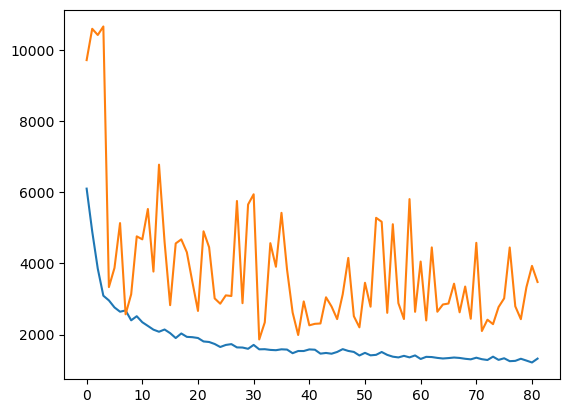

In [103]:
fox = pd.DataFrame(history.history)
fox['loss'].plot()
fox['val_loss'].plot()

In [54]:
# def ensemble_model_generator(model):
#     X = np.concatenate((X_train_preprocessed,X_val_preprocessed),axis=0)
#     y = np.concatenate((y_train_pre,y_val_pre),axis=0)


#     models = []
#     for i in range(0,3,1):
#         sel_X = X[int(i*0.316*X.shape[0]):int((i+1)*0.316*X.shape[0])]
#         sel_y = y[int(i*0.316*y.shape[0]):int((i+1)*0.316*y.shape[0])]

#         sel_X_val = X[int(i*(0.316+0.05)*X.shape[0]):int((i+1)*(0.316+0.05)*X.shape[0])]
#         sel_y_val = y[int(i*(0.316+0.05)*y.shape[0]):int((i+1)*(0.316+0.05)*y.shape[0])]
#         new_model = model
#         new_model.fit(sel_X,pd.Series(sel_y),
#                 epochs=500, batch_size=60,
#                 validation_data=[sel_X_val, pd.Series(sel_y_val)],
#                 callbacks=tuner_callback, 
#                 verbose=True)        
#         models.append(new_model)
#     models.append(model)
#     return models

# cv_result = ensemble_model_generator(model)


In [55]:
# def ensemble(models,X):
#     predictions = []
#     for i in range(0,len(models),1):
#         pred_sel = models[i].predict(X)
#         predictions.append(pred_sel)
#     output = np.sum(predictions,axis=0)/len(models)
#     return output

In [56]:
# cv_result

In [57]:
# ens_train_pred = ensemble(cv_result, X_train_preprocessed)
# ens_val_pred = ensemble(cv_result, X_val_preprocessed)
# ens_test_pred = ensemble(cv_result, X_test_preprocessed)

<h1> Large  tuner end

In [104]:
# model.fit(X_train_preprocessed, y_train_pre)
train_pred = model.predict(X_train_preprocessed)
val_pred = model.predict(X_val_preprocessed)
test_pred = model.predict(X_test_preprocessed)

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [106]:
X_val

,FX_EURONOK,Interest_rate,Food_index
Date,,,
2019-05-27,9.76837,0.5,95.340978
2019-06-03,9.80312,0.5,95.086631
2019-06-10,9.76780,0.5,95.086631
2019-06-17,9.65683,0.5,95.086631
2019-06-24,9.67580,0.5,95.086631
...,...,...,...
2021-08-09,10.26537,0.0,92.203018
2021-08-16,10.44622,0.0,92.203018
2021-08-23,10.27570,0.0,92.203018


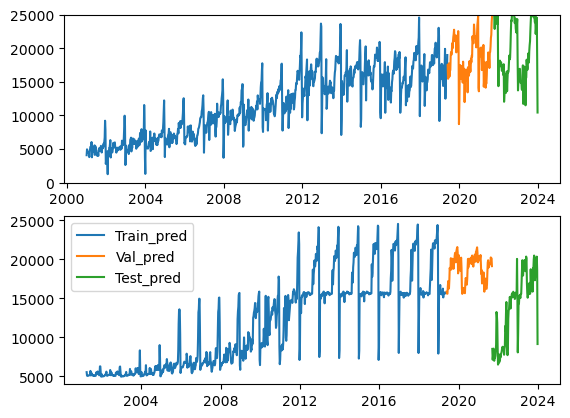

In [105]:
fig,ax = plt.subplots(2)
ax[0].plot(y_train, label='Train')
ax[0].plot(y_val, label='Valid')
ax[0].plot(y_test, label='Test')
ax[0].set_ylim(0,25000)

ax[1].plot(X_train.index[13:], train_pred, label='Train_pred')
ax[1].plot(X_val.index[:], val_pred, label='Val_pred')
ax[1].plot(X_test.index[:], test_pred, label='Test_pred')
# ax[1].set_ylim(0,35000)

plt.legend()
plt.show()

In [82]:
# from sklearn.metrics import root_mean_squared_error as RMSE
# from sklearn.metrics import mean_absolute_percentage_error as 
from sklearn.metrics import mean_absolute_error as MAE


In [41]:
# y_train

In [83]:
MAE(y_train_pre, train_pred)

2761.1734511990735

In [43]:
1360/11700

0.11623931623931624

<h2> Residual analysis

In [44]:
# train_pred

In [45]:
residuals = val_pred.flatten() - y_val_pre

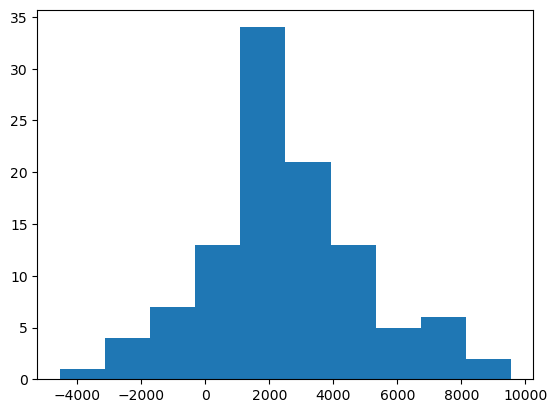

In [46]:
plt.hist(residuals)
plt.show()

In [47]:
my = np.mean(residuals)

In [48]:
std = np.std(residuals)
std

2550.785480776983

In [49]:
print('lower') 
my- std*1.28

lower


-723.9240658957178

In [50]:
print('upper') 
my+ std*1.28

upper


5806.086764893359

In [51]:
std*100

255078.5480776983

In [52]:
high_list = []
low_list = []
for i in range(0,len(test_pred),1):
    high_sel = test_pred[i][0] + std*(i+1)
    low_sel = test_pred[i][0] - std*(i+1)
    high_list.append(high_sel)
    low_list.append(low_sel)
    

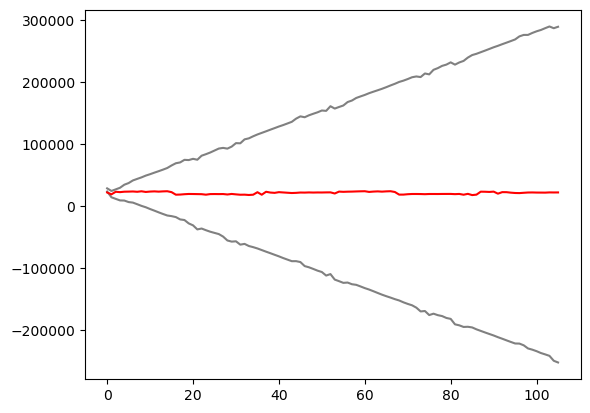

In [53]:
plt.plot(high_list,color='grey')
plt.plot(low_list, color='grey')
plt.plot(val_pred, color='red')
plt.show()